In [285]:
# Import necesary libraries etc.

import os
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

"""

Here we need to define the current year, and previous 2 years in order to have history
"""

Today_Date = datetime.datetime.now()
Current_Start = datetime.datetime(2022, 9, 8) ## -> this is manually set each year


if Today_Date < Current_Start:
    Year_Variable = (Current_Start.year) - 1
else:
    Year_Variable = Current_Start.year

year_prior2 = str(Year_Variable - 2)
year_prior1 = str(Year_Variable - 1)
year_current = str(Year_Variable)

print('Library Import Complete')
print('Years in question: ' + year_current,year_prior1,year_prior2)

Library Import Complete
Years in question: 2022 2021 2020


In [286]:
## import data to be analyzed
# In this case, we are going to look at Weekly Scores by position for the 'Current Year'
df = pd.read_csv(r'D:\Geoff\Analytics\Fantasy Football\PBI Source Data\FANTASY_KPI_ROSTER.csv')

#we want to look at the current season only
df = df[df['FANTASY_YEAR_GROUP'] == "Current Year"]
##################################################################

#Bring in Han Shot First roster
df_ROSTER = pd.read_csv(r'D:\Geoff\Analytics\Fantasy Football\PBI Source Data\HAS_SHOT_FIRST_ROSTER.csv')
df_DRAFT = pd.read_csv(r'D:\Geoff\Analytics\Fantasy Football\PBI Source Data\FANTASY_DRAFT.csv')

# Create Unique Join to bring in current Han Shot First Data
df_ROSTER['FANTASY_YEAR'] = year_current
df_ROSTER['UNIQUE_JOIN'] = df_ROSTER['Player'] + df_ROSTER['Position'] + df_ROSTER['FANTASY_YEAR']
#df = df_PLAYERS.filter(['UNIQUE_JOIN','WEEKLY_SCORE','TEAM'])
df_ROSTER = pd.merge(df_ROSTER,df, on='UNIQUE_JOIN',how='left').fillna(0).drop_duplicates()

# Define drafted flag
#define condition of each value
conditions = [
    (df_DRAFT['RELEVENCE_TO_MY_PICK'] == "PICK"),
    (df_DRAFT['RELEVENCE_TO_MY_PICK'] == "Keeper"),
    (df_DRAFT['RELEVENCE_TO_MY_PICK'] == 0)
]

# Define result depending on the condition met
values = ['Y','K','']

# Apply Condition -> result logic as a new column in the DataFrame
df_DRAFT['DRAFTED'] = np.select(conditions, values)

df_DRAFT = df_DRAFT.filter(['UNIQUE_JOIN','DRAFTED'])

df_ROSTER = pd.merge(df_ROSTER,df_DRAFT, on='UNIQUE_JOIN',how='left').fillna('N').drop_duplicates()

df_fantasy = df_ROSTER

#########################################################################################

"""

Define min count of games played to determine a baseline for a full season
    -The idea is that if you dont play the minimum games then you arent counted towards the full season
    -This should omit players that got injured early/got little play
            -Those are outliers that throw off data

"""
# Define minimun number of games
df_games = df.filter(['UNIQUE_JOIN','GAMES_PLAYED']).drop_duplicates()
min_games = df_games['GAMES_PLAYED'].max() - 5

# Build out flag for min games played benchmark
#define condition of each value
conditions = [
    (df_games['GAMES_PLAYED'] >= min_games),
    (df_games['GAMES_PLAYED'] < min_games)
]

# Define result depending on the condition met
values = ['Y','N']

# Apply Condition -> result logic as a new column in the DataFrame
df_games['GAMES_PLAYED_FLAG'] = np.select(conditions, values)

#clean up ref dataframe
df_games = df_games.filter(['UNIQUE_JOIN','GAMES_PLAYED_FLAG'])

# merge games played flag to base dataframe
df = pd.merge(df,df_games, on='UNIQUE_JOIN',how='left').fillna(0).drop_duplicates()


df_base = df

df_base.head()

,UNIQUE_JOIN,PLAYER_NAME,PLAYER_POSITION,GAMES_PLAYED,FANTASY_YEAR,YTD_SCORE,WEEKLY_SCORE,WEEKLY_SCORE_GROUP,FANTASY_YEAR_GROUP,TEAM_JOIN,TEAM,GAMES_PLAYED_FLAG
0,Patrick MahomesQB2022,Patrick Mahomes,QB,17,2022,398.40,23.435294,15 - 25,Current Year,KAN2022,KAN,Y
1,Justin HerbertQB2022,Justin Herbert,QB,17,2022,254.26,14.956471,10 - 15,Current Year,LAC2022,LAC,Y
2,Tom BradyQB2022,Tom Brady,QB,17,2022,253.66,14.921176,10 - 15,Current Year,0,0,Y
3,Kirk CousinsQB2022,Kirk Cousins,QB,17,2022,255.58,15.034118,15 - 25,Current Year,MIN2022,MIN,Y
4,Joe BurrowQB2022,Joe Burrow,QB,16,2022,319.70,19.981250,15 - 25,Current Year,CIN2022,CIN,Y


In [287]:
# Create a Function that will define the Mean and standard Deviation of a set of data in order to group accordingly

def calculate_standard_deviation(df_base, positions):
    dfs = {}
    for position in positions:
        df = df_base.loc[df_base['PLAYER_POSITION'] == position].copy()
        df_a = df[df['GAMES_PLAYED_FLAG'] == "Y"]
        df_a = df_a.filter(['WEEKLY_SCORE'])

        # calculate the standard deviation of the "values" column
        mean = df_a['WEEKLY_SCORE'].mean()
        std_dev = df_a['WEEKLY_SCORE'].std()

        # add a new column to the dataframe that holds the standard deviation value
        df['mean'] = mean
        df['standard_deviation'] = std_dev
        df['Plus 1 Std'] = df['mean'] + df['standard_deviation']
        df['Plus 2 Std'] = df['Plus 1 Std'] + df['standard_deviation']
        df['Minus 1 Std'] = df['mean'] - df['standard_deviation']
        df['Minus 2 Std'] = df['Minus 1 Std'] - df['standard_deviation']

        #define condition of each value
        conditions = [            (df['WEEKLY_SCORE'] >= df['Plus 2 Std']),
            (df['WEEKLY_SCORE'] >= df['Plus 1 Std']),
            (df['WEEKLY_SCORE'] >= df['mean']),
            (df['WEEKLY_SCORE'] >= df['Minus 1 Std']),
            (df['WEEKLY_SCORE'] >= df['Minus 2 Std']),
            (df['WEEKLY_SCORE'] < df['Minus 2 Std'])
        ]

        # Define result depending on the condition met
        values = ['> 2 STDV+','2 STDV+','1 STDV+','1 STDV-','2 STDV-','> 2 STDV-']

        # Apply Condition -> result logic as a new column in the DataFrame
        df['STANDARD_DEV_CATEGORY'] = np.select(conditions, values)
        
        # add the resulting dataframe to the dictionary of dataframes
        dfs[position] = df
    
    # return the dictionary of dataframes
    return dfs

print('done')

done


In [288]:
# Create DataFrames for each position for analysis

df_base = df
positions = ['QB', 'WR', 'RB', 'TE']
dfs = calculate_standard_deviation(df_base, positions)

df_qb = dfs['QB']
df_wr = dfs['WR']
df_rb = dfs['RB']
df_te = dfs['TE']

print('done')

done


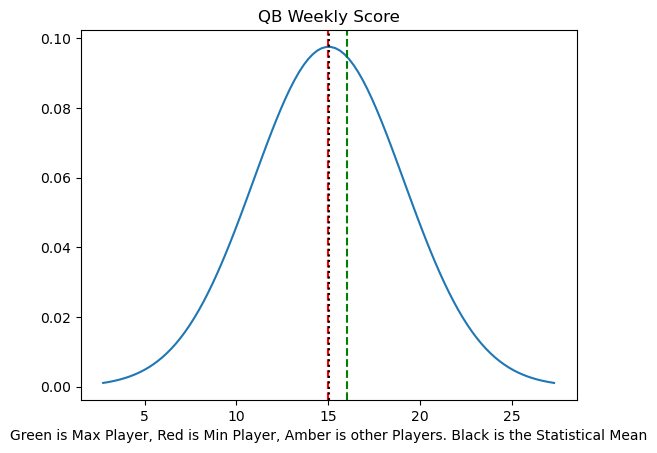

Statistical Mean: 15.017534719805086
Standard Deviation: 4.090375067498266

Han Shot First QB: Player Detail


,Player,Position,WEEKLY_SCORE,TEAM,DRAFTED,STANDARD_DEV_CATEGORY,Line Color
0,Geno Smith,QB,15.992941,SEA,N,1 STDV+,Green
9,Justin Herbert,QB,14.956471,LAC,K,1 STDV-,Red


In [289]:
#####################################################################
#                                                                   #
#                     QB Analytics                                  #
#                                                                   #
#####################################################################

## Set up data for analytics

# set the player position
pos_ref = "QB"

# create a dataframe to define the Mean and Standard Dev of the Weekly Score
df = df_qb

#Create a dataframe to bring in the Standard Dev Category
df_a = df.filter(['UNIQUE_JOIN','STANDARD_DEV_CATEGORY'])

#Create a dataframe to reference my Fantasy team
df_b = pd.merge(df_fantasy,df_a, on='UNIQUE_JOIN',how='left').fillna(0).drop_duplicates()

# Filter the Fantasy team dataframe to the position in question
df_b = df_b[df_b['PLAYER_POSITION'].isin([pos_ref])]

#####################################################################

# Define Measures for the bell curve of all players in the position
mean = df['mean'].min()
std_dev = df['standard_deviation'].min()

# Define Measures for the bell curve of my fantasy players in the position
max_score = df_b['WEEKLY_SCORE'].max()
min_score = df_b['WEEKLY_SCORE'].min()

#####################################################################

## Build the Bell curve ##

# Generate a range of values to use for the x-axis of the bell curve
x_values = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)

# Create a function to calculate the y-values of the bell curve
def bell_curve(x, mean, std_dev):
    return 1/(std_dev * np.sqrt(2*np.pi)) * np.exp(-(x - mean)**2 / (2*std_dev**2))

# Use matplotlib to plot the bell curve
plt.plot(x_values, bell_curve(x_values, mean, std_dev))
plt.title(pos_ref + ' Weekly Score')
plt.xlabel('Green is Max Player, Red is Min Player, Amber is other Players. Black is the Statistical Mean')

# Add a vertical line at the location of the Min/Max/Other player's score

for i, row in df_b.iterrows():
    score = row['WEEKLY_SCORE']
    if score == max_score:
        plt.axvline(x=max_score, color='green', linestyle='--')
    elif score == min_score:
        plt.axvline(x=min_score, color='red', linestyle='--')       
    else:
        plt.axvline(x=score, color='orange', linestyle='--')
        
# Plot the Statistical MEan value of the curve for reference
plt.axvline(x=mean, color='black', linestyle=':')

#Plot the bell curve that was created above
plt.show()  
#####################################################################

## Create a Summary dataframe to show details of my players in the position

#Filter out unwanted columns
df_b = df_b.filter(['Player','Position','WEEKLY_SCORE','TEAM','DRAFTED','STANDARD_DEV_CATEGORY'])

# Create a column to help with a legend

#define condition of each value
conditions = [
    (df_b['WEEKLY_SCORE'] == min_score),
    (df_b['WEEKLY_SCORE'] == max_score)
]

# Define result depending on the condition met
values = ['Red','Green']

# Apply Condition -> result logic as a new column in the DataFrame
df_b['Line Color'] = np.select(conditions, values)

# We want RAG -> this replaces anything that isnt Red or Green with Orange
df_b['Line Color'] = df_b['Line Color'].replace('0','Orange')

df_b = df_b.sort_values(by='WEEKLY_SCORE', ascending=False)

print('Statistical Mean: ' + str(mean))
print('Standard Deviation: ' + str(std_dev))
print('')
print('Han Shot First ' + pos_ref + ': Player Detail')
df_b

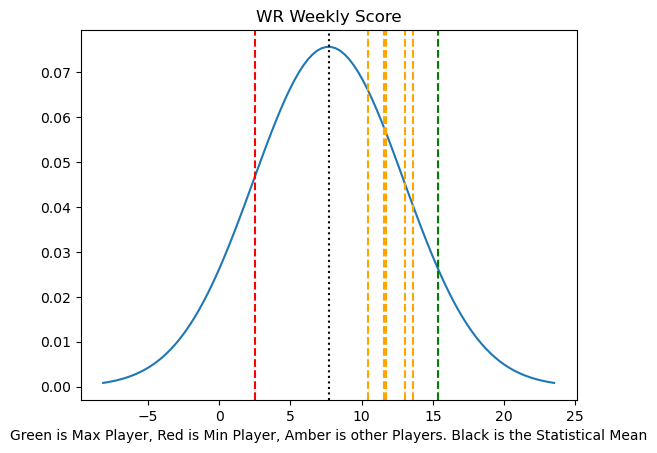

Statistical Mean: 7.685151156944594
Standard Deviation: 5.27384571926502

Han Shot First WR: Player Detail


,Player,Position,WEEKLY_SCORE,TEAM,DRAFTED,STANDARD_DEV_CATEGORY,Line Color
7,Jaylen Waddle,WR,15.364706,MIA,Y,2 STDV+,Green
10,Mike Williams,WR,13.576923,LAC,Y,2 STDV+,Orange
1,Jakobi Meyers,WR,13.021429,LVR,N,2 STDV+,Orange
11,D.J. Moore,WR,11.711765,CHI,Y,1 STDV+,Orange
6,Gabriel Davis,WR,11.573333,0,Y,1 STDV+,Orange
12,Josh Palmer,WR,10.456250,LAC,N,1 STDV+,Orange
2,Jameson Williams,WR,2.516667,DET,N,1 STDV-,Red


In [290]:
#####################################################################
#                                                                   #
#                     WR Analytics                                  #
#                                                                   #
#####################################################################

## Set up data for analytics

# set the player position
pos_ref = "WR"

# create a dataframe to define the Mean and Standard Dev of the Weekly Score
df = df_wr

#Create a dataframe to bring in the Standard Dev Category
df_a = df.filter(['UNIQUE_JOIN','STANDARD_DEV_CATEGORY'])

#Create a dataframe to reference my Fantasy team
df_b = pd.merge(df_fantasy,df_a, on='UNIQUE_JOIN',how='left').fillna(0).drop_duplicates()

# Filter the Fantasy team dataframe to the position in question
df_b = df_b[df_b['PLAYER_POSITION'].isin([pos_ref])]

#####################################################################

# Define Measures for the bell curve of all players in the position
mean = df['mean'].min()
std_dev = df['standard_deviation'].min()

# Define Measures for the bell curve of my fantasy players in the position
max_score = df_b['WEEKLY_SCORE'].max()
min_score = df_b['WEEKLY_SCORE'].min()

#####################################################################

## Build the Bell curve ##

# Generate a range of values to use for the x-axis of the bell curve
x_values = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)

# Create a function to calculate the y-values of the bell curve
def bell_curve(x, mean, std_dev):
    return 1/(std_dev * np.sqrt(2*np.pi)) * np.exp(-(x - mean)**2 / (2*std_dev**2))

# Use matplotlib to plot the bell curve
plt.plot(x_values, bell_curve(x_values, mean, std_dev))
plt.title(pos_ref + ' Weekly Score')
plt.xlabel('Green is Max Player, Red is Min Player, Amber is other Players. Black is the Statistical Mean')

# Add a vertical line at the location of the Min/Max/Other player's score

for i, row in df_b.iterrows():
    score = row['WEEKLY_SCORE']
    if score == max_score:
        plt.axvline(x=max_score, color='green', linestyle='--')
    elif score == min_score:
        plt.axvline(x=min_score, color='red', linestyle='--')       
    else:
        plt.axvline(x=score, color='orange', linestyle='--')
        
# Plot the Statistical MEan value of the curve for reference
plt.axvline(x=mean, color='black', linestyle=':')

#Plot the bell curve that was created above
plt.show()  
#####################################################################

## Create a Summary dataframe to show details of my players in the position

#Filter out unwanted columns
df_b = df_b.filter(['Player','Position','WEEKLY_SCORE','TEAM','DRAFTED','STANDARD_DEV_CATEGORY'])

# Create a column to help with a legend

#define condition of each value
conditions = [
    (df_b['WEEKLY_SCORE'] == min_score),
    (df_b['WEEKLY_SCORE'] == max_score)
]

# Define result depending on the condition met
values = ['Red','Green']

# Apply Condition -> result logic as a new column in the DataFrame
df_b['Line Color'] = np.select(conditions, values)

# We want RAG -> this replaces anything that isnt Red or Green with Orange
df_b['Line Color'] = df_b['Line Color'].replace('0','Orange')

df_b = df_b.sort_values(by='WEEKLY_SCORE', ascending=False)

print('Statistical Mean: ' + str(mean))
print('Standard Deviation: ' + str(std_dev))
print('')
print('Han Shot First ' + pos_ref + ': Player Detail')
df_b

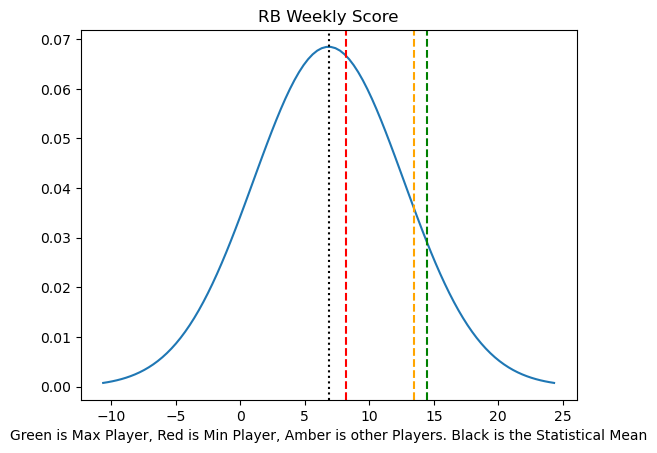

Statistical Mean: 6.842678353781296
Standard Deviation: 5.826398603607329

Han Shot First RB: Player Detail


,Player,Position,WEEKLY_SCORE,TEAM,DRAFTED,STANDARD_DEV_CATEGORY,Line Color
3,Dalvin Cook,RB,14.458824,MIN,Y,2 STDV+,Green
4,Kenneth Walker III,RB,13.500000,SEA,N,2 STDV+,Orange
8,Isiah Pacheco,RB,8.176471,KAN,N,1 STDV+,Red


In [291]:
#####################################################################
#                                                                   #
#                     RB Analytics                                  #
#                                                                   #
#####################################################################

## Set up data for analytics

# set the player position
pos_ref = "RB"

# create a dataframe to define the Mean and Standard Dev of the Weekly Score
df = df_rb

#Create a dataframe to bring in the Standard Dev Category
df_a = df.filter(['UNIQUE_JOIN','STANDARD_DEV_CATEGORY'])

#Create a dataframe to reference my Fantasy team
df_b = pd.merge(df_fantasy,df_a, on='UNIQUE_JOIN',how='left').fillna(0).drop_duplicates()

# Filter the Fantasy team dataframe to the position in question
df_b = df_b[df_b['PLAYER_POSITION'].isin([pos_ref])]

#####################################################################

# Define Measures for the bell curve of all players in the position
mean = df['mean'].min()
std_dev = df['standard_deviation'].min()

# Define Measures for the bell curve of my fantasy players in the position
max_score = df_b['WEEKLY_SCORE'].max()
min_score = df_b['WEEKLY_SCORE'].min()

#####################################################################

## Build the Bell curve ##

# Generate a range of values to use for the x-axis of the bell curve
x_values = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)

# Create a function to calculate the y-values of the bell curve
def bell_curve(x, mean, std_dev):
    return 1/(std_dev * np.sqrt(2*np.pi)) * np.exp(-(x - mean)**2 / (2*std_dev**2))

# Use matplotlib to plot the bell curve
plt.plot(x_values, bell_curve(x_values, mean, std_dev))
plt.title(pos_ref + ' Weekly Score')
plt.xlabel('Green is Max Player, Red is Min Player, Amber is other Players. Black is the Statistical Mean')

# Add a vertical line at the location of the Min/Max/Other player's score

for i, row in df_b.iterrows():
    score = row['WEEKLY_SCORE']
    if score == max_score:
        plt.axvline(x=max_score, color='green', linestyle='--')
    elif score == min_score:
        plt.axvline(x=min_score, color='red', linestyle='--')       
    else:
        plt.axvline(x=score, color='orange', linestyle='--')
        
# Plot the Statistical MEan value of the curve for reference
plt.axvline(x=mean, color='black', linestyle=':')

#Plot the bell curve that was created above
plt.show()  
#####################################################################

## Create a Summary dataframe to show details of my players in the position

#Filter out unwanted columns
df_b = df_b.filter(['Player','Position','WEEKLY_SCORE','TEAM','DRAFTED','STANDARD_DEV_CATEGORY'])

# Create a column to help with a legend

#define condition of each value
conditions = [
    (df_b['WEEKLY_SCORE'] == min_score),
    (df_b['WEEKLY_SCORE'] == max_score)
]

# Define result depending on the condition met
values = ['Red','Green']

# Apply Condition -> result logic as a new column in the DataFrame
df_b['Line Color'] = np.select(conditions, values)

# We want RAG -> this replaces anything that isnt Red or Green with Orange
df_b['Line Color'] = df_b['Line Color'].replace('0','Orange')

df_b = df_b.sort_values(by='WEEKLY_SCORE', ascending=False)

print('Statistical Mean: ' + str(mean))
print('Standard Deviation: ' + str(std_dev))
print('')
print('Han Shot First ' + pos_ref + ': Player Detail')
df_b

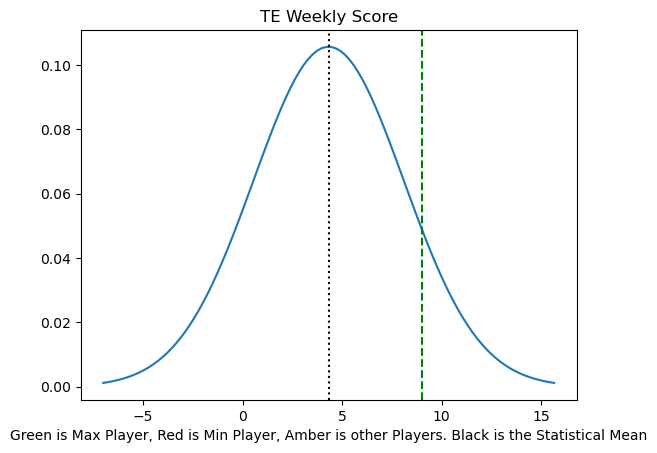

Statistical Mean: 4.314465236320772
Standard Deviation: 3.7758248604835707

Han Shot First TE: Player Detail


,Player,Position,WEEKLY_SCORE,TEAM,DRAFTED,STANDARD_DEV_CATEGORY,Line Color
5,Taysom Hill,TE,8.9875,0,N,2 STDV+,Red


In [292]:
#####################################################################
#                                                                   #
#                     TE Analytics                                  #
#                                                                   #
#####################################################################

## Set up data for analytics

# set the player position
pos_ref = "TE"

# create a dataframe to define the Mean and Standard Dev of the Weekly Score
df = df_te

#Create a dataframe to bring in the Standard Dev Category
df_a = df.filter(['UNIQUE_JOIN','STANDARD_DEV_CATEGORY'])

#Create a dataframe to reference my Fantasy team
df_b = pd.merge(df_fantasy,df_a, on='UNIQUE_JOIN',how='left').fillna(0).drop_duplicates()

# Filter the Fantasy team dataframe to the position in question
df_b = df_b[df_b['PLAYER_POSITION'].isin([pos_ref])]

#####################################################################

# Define Measures for the bell curve of all players in the position
mean = df['mean'].min()
std_dev = df['standard_deviation'].min()

# Define Measures for the bell curve of my fantasy players in the position
max_score = df_b['WEEKLY_SCORE'].max()
min_score = df_b['WEEKLY_SCORE'].min()

#####################################################################

## Build the Bell curve ##

# Generate a range of values to use for the x-axis of the bell curve
x_values = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)

# Create a function to calculate the y-values of the bell curve
def bell_curve(x, mean, std_dev):
    return 1/(std_dev * np.sqrt(2*np.pi)) * np.exp(-(x - mean)**2 / (2*std_dev**2))

# Use matplotlib to plot the bell curve
plt.plot(x_values, bell_curve(x_values, mean, std_dev))
plt.title(pos_ref + ' Weekly Score')
plt.xlabel('Green is Max Player, Red is Min Player, Amber is other Players. Black is the Statistical Mean')

# Add a vertical line at the location of the Min/Max/Other player's score

for i, row in df_b.iterrows():
    score = row['WEEKLY_SCORE']
    if score == max_score:
        plt.axvline(x=max_score, color='green', linestyle='--')
    elif score == min_score:
        plt.axvline(x=min_score, color='red', linestyle='--')       
    else:
        plt.axvline(x=score, color='orange', linestyle='--')
        
# Plot the Statistical MEan value of the curve for reference
plt.axvline(x=mean, color='black', linestyle=':')

#Plot the bell curve that was created above
plt.show()  
#####################################################################

## Create a Summary dataframe to show details of my players in the position

#Filter out unwanted columns
df_b = df_b.filter(['Player','Position','WEEKLY_SCORE','TEAM','DRAFTED','STANDARD_DEV_CATEGORY'])

# Create a column to help with a legend

#define condition of each value
conditions = [
    (df_b['WEEKLY_SCORE'] == min_score),
    (df_b['WEEKLY_SCORE'] == max_score)
]

# Define result depending on the condition met
values = ['Red','Green']

# Apply Condition -> result logic as a new column in the DataFrame
df_b['Line Color'] = np.select(conditions, values)

# We want RAG -> this replaces anything that isnt Red or Green with Orange
df_b['Line Color'] = df_b['Line Color'].replace('0','Orange')

df_b = df_b.sort_values(by='WEEKLY_SCORE', ascending=False)

print('Statistical Mean: ' + str(mean))
print('Standard Deviation: ' + str(std_dev))
print('')
print('Han Shot First ' + pos_ref + ': Player Detail')
df_b